In [1]:
import os
import shutil
import requests
import itertools

import numpy as np
import pandas as pd
import networkx as nx

from lingam import VARLiNGAM

import matplotlib.pyplot as plt
import graphviz as gv
from IPython.display import display, Markdown

# versions
import scipy
import lingam
import sklearn
import matplotlib
for lib in [np, pd, scipy, lingam, sklearn, matplotlib, gv]:
    print(lib.__name__, lib.__version__)

numpy 1.24.4
pandas 2.0.3
scipy 1.10.1
lingam 1.9.1
sklearn 1.3.2
matplotlib 3.7.5
graphviz 0.20.3


## LiNGDの準備

In [2]:
def _get_code(url, dirname="."):
    res = requests.get(url)
    if res.status_code != 200:
        raise RuntimeError("Couldn't get a source code.")
    
    with open(dirname + os.sep + url.split("/")[-1], "w") as f:
        f.write(res.text)

# destinaiton of downloaded source code
dirname = "lingd"
if os.path.isdir(dirname):
    shutil.rmtree(dirname)
os.mkdir(dirname)

# download required source code
_get_code("https://raw.githubusercontent.com/cdt15/lingd/refs/heads/main/lingd/lingd.py", dirname=dirname)
_get_code("https://raw.githubusercontent.com/cdt15/lingd/refs/heads/main/lingd/murty.r", dirname=dirname)
_get_code("https://raw.githubusercontent.com/cdt15/lingd/refs/heads/main/lingd/__init__.py", dirname=dirname)

from lingd import LiNGD

# check that dounwloaded source code works properly
B = np.array([[0, 0, 0], [0.5, 0, 0], [0.5, 0.5, 0]])
e = np.random.uniform(size=(len(B), 100))
X = ((np.eye(len(B)) - B) @ e).T
try:
    model = LiNGD()
    model.fit(X)
except:
    raise RuntimeError("Check that the R and muRty packages are installed and that the path to the Rscript is set correctly.")

## 関数定義

In [3]:
# 係数の範囲
COEF_RANGE = 0, 0.3

def _make_dag(n_features=8, is_shuffle=True):
    sign = np.random.choice([-1, 1], size=(n_features, n_features))
    coef = np.random.uniform(*COEF_RANGE, size=(n_features, n_features))
    sparse = np.random.choice([0, 1], p=[0.3, 0.7], size=(n_features, n_features))

    graph = np.tril(sign * coef * sparse, k=-1)
    graph[np.isclose(graph, 0)] = 0
    
    if is_shuffle:
        indices = np.random.permutation(n_features)
        graph = graph[indices][:, indices]
    
    G = nx.from_numpy_array(graph.T, create_using=nx.DiGraph)
    causal_order = list(nx.topological_sort(G))
    
    return graph, causal_order

def _make_tau_coefs(tau_len, n_features=8):
    coefs = []
    for i in range(tau_len):
        sign = np.random.choice([-1, 1], size=(n_features, n_features))
        coef = np.random.uniform(*COEF_RANGE, size=(n_features, n_features))
        sparse = np.random.choice([0, 1], p=[0.5, 0.5], size=(n_features, n_features))

        coef = sign * coef * sparse
        coef[np.isclose(coef, 0)] = 0
        
        coefs.append(coef)
    return coefs

def _generate_var_graph(n_features=4, n_lags=1, is_shuffle=True):
    B = np.empty((n_lags + 1, n_features, n_features))
    
    B[0], causal_order = _make_dag(n_features=n_features, is_shuffle=is_shuffle)
    B[1:] = _make_tau_coefs(n_lags, n_features=n_features)
    return B, causal_order

def _get_example_graph():
    B = np.array([
        [
            [0,-0.12,0,0,0],
            [0,0,0,0,0],
            [-0.41,0.01,0,-0.02,0],
            [0.04,-0.22,0,0,0],
            [0.15,0,-0.03,0,0],
        ],
        [
            [-0.32,0,0.12,0.32,0],
            [0,-0.35,-0.1,-0.46,0.4],
            [0,0,0.37,0,0.46],
            [-0.38,-0.1,-0.24,0,-0.13],
            [0,0,0,0,0],
        ]
    ])

    causal_order = [1, 0, 3, 2, 4]
    
    return B, causal_order

def _make_var_data(B, T=100):
    k = len(B) - 1
    n_features = len(B[0])
    
    I_minus_B0_inv = np.linalg.pinv(np.eye(n_features) - B[0])

    X = np.empty((T * 2, n_features))

    for t in range(T * 2):
        lag = min(k, t)

        lag_data = np.array(X[t - lag:t])
        if len(lag_data) == 0:
            lag_data = 0
        else:
            lag_data = np.hstack(B[1:]) @ np.vstack(lag_data[::-1].T) 

        e = np.random.uniform(size=(n_features, 1))
        X[t] = (I_minus_B0_inv @ (lag_data + e)).T

    return X[-T:]
    
def _make_cycle_path(B, max_trial = 10):
    """ 即時間の関係に巡回を与える """
    G = nx.from_numpy_array(B[0].T, create_using=nx.DiGraph)
    
    # 探索するパス
    pairs = list(itertools.permutations(range(len(B[0])), 2))
    pairs = np.random.permutation(pairs)
    
    target = None
    for s, d in pairs:
        if not nx.is_simple_path(G, (s, d)):
            continue
        
        # 経路長1しかないものはなるべく防ぐ。
        if True:
            paths = nx.shortest_simple_paths(G, s, d)
            path_lens = [len(p) - 1 for p in paths]
            if max(path_lens) < 2:
                target = (s, d)
                continue
            
        # 逆向きのパスを追加
        target = (s, d)
        break
    
    if target is None:
        raise ValueError("no path")
        
    Bc = B.copy()
    Bc[0][target[0], target[1]] = np.random.choice([-1, 1]) * np.random.uniform(*COEF_RANGE)
    
    return Bc

def _visualize(B_true, B_est, s=10):
    fig, axes = plt.subplots(1, len(B_true), figsize=(len(B_true)*3, 3))
    for i, (true, est) in enumerate(zip(B_true, B_est)):
        axes[i].scatter(true.ravel(), est.ravel(), s=s)
        axes[i].set_xlabel("true coefs")
        axes[i].set_ylabel("estimated coefs")
        axes[i].set_title(f"tau={i}")
    plt.tight_layout()
    plt.show()

## 試しに実行
100回実行して、その結果をひとまとめの散布図に描画する。

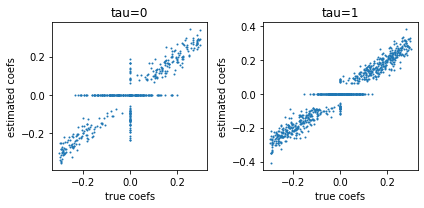

In [4]:
B_true = []
B_est = []

for i in range(100):
    B, causal_order = _generate_var_graph(is_shuffle=False)
    X = _make_var_data(B, T=1000)
    
    # 係数の大きさに注意。発散しないように。
    if np.isnan(X).sum().sum() > 0:
        raise ValueError("X has nans")

    model = VARLiNGAM(lags=1, prune=True)
    model.fit(X)
    
    B_true.append(B)
    B_est.append(model.adjacency_matrices_)

B_true = np.array(B_true)
B_est = np.array(B_est)

# 各時刻ごとに結果の係数をひとまとめにする(軸を入れ替えて100回分をそれぞれconcatして元に戻す)
concat = lambda x: np.transpose(np.concatenate(np.transpose(x, (0, 2, 3, 1))), (2, 0, 1))
_visualize(concat(B_true), concat(B_est), s=1)

小さい係数が枝刈りされている？VARLiNGAMのpruneをFalseにすると、ラグ側で特に十字が薄まる。

## 巡回を与える

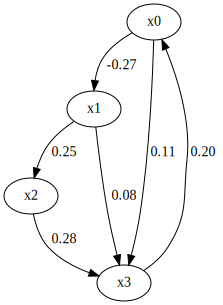

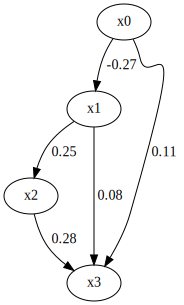

In [5]:
# おためし
B, causal_order = _generate_var_graph(is_shuffle=False)
Bc = _make_cycle_path(B)

display(lingam.utils.make_dot(Bc[0], lower_limit=0))
display(lingam.utils.make_dot(B[0], lower_limit=0))

同様に実行する。

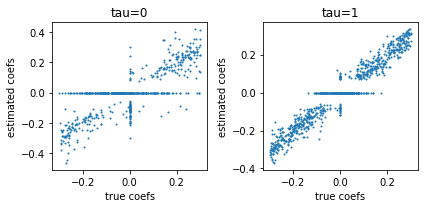

In [6]:
B_true = []
B_est = []

for i in range(100):
    B, causal_order = _generate_var_graph(is_shuffle=False)
    
    # 追加分
    B = _make_cycle_path(B)
    
    X = _make_var_data(B, T=1000)
    
    # 係数の大きさに注意。発散しないように。
    if np.isnan(X).sum().sum() > 0:
        raise ValueError("X has nans")

    model = VARLiNGAM(lags=1, prune=True)
    model.fit(X)
    
    B_true.append(B)
    B_est.append(model.adjacency_matrices_)

B_true = np.array(B_true)
B_est = np.array(B_est)

# 各時刻ごとに結果の係数をひとまとめにする(軸を入れ替えて100回分をそれぞれconcatして元に戻す)
concat = lambda x: np.transpose(np.concatenate(np.transpose(x, (0, 2, 3, 1))), (2, 0, 1))
_visualize(concat(B_true), concat(B_est), s=1)

巡回のせいか、tau=0の方は、先ほどよりも予測値が0になってしまうことが増えている。巡回が部分が関係ないラグ部分はそれほど変わらない。

## 巡回VARLiNGAMの実装

In [7]:
from sklearn.utils import check_array, check_scalar, check_random_state

class CyclicVARLiNGAM(VARLiNGAM):
    
    def __init__(self, k=1, random_state=None, **kwargs):
        if "lingam_model" in kwargs:
            del kwargs["lingam_model"]
        
        super().__init__(**kwargs, random_state=random_state)
        
        self._k = k
        self._random_state = random_state
    
    # 上書き
    def fit(self, X):
        """Fit the model to X.

        Parameters
        ----------
        X: array-like, shape (n_samples, n_features)
            Training data, where ``n_samples`` is the number of samples
            and ``n_features`` is the number of features.

        returns
        -------
        self : object
            Returns the instance itself.
        """
        self._causal_order = None
        self._adjacency_matrices = None
        
        # LiNGD
        self._causal_orders = []
        self._adjacency_matrices_list = []
        self._costs = []
        self._is_stables = []

        # check inputs
        X = check_array(X)
        k = check_scalar(self._k, "k", int, min_val=1)
        random_state = check_random_state(self._random_state)

        M_taus = self._ar_coefs

        if M_taus is None:
            M_taus, lags, residuals = self._estimate_var_coefs(X)
        else:
            lags = M_taus.shape[0]
            residuals = self._calc_residuals(X, M_taus, lags)

        model = LiNGD(k=k)
        model.fit(residuals)

        B_taus_list = []
        for is_stables, adj, costs, in zip(model.is_stables_, model.adjacency_matrices_, model.costs_):
            B_taus = self._calc_b(X, adj, M_taus)
            B_taus_list.append(B_taus)
            
            # XXX: LiNGDにはcausal_orderがない！
            #if self._prune:
            #    B_taus = self._pruning(X, B_taus, model.causal_order_)
        
        # 最高の結果(stableかつ最もコストが低い)を選ぶ
        if np.all(~model.is_stables_):
            best_index = np.argmin(model.costs_).ravel()[0]
        else:
            best_index = np.argmin(model.costs_[model.is_stables_]).ravel()[0]
        B_taus_best = B_taus_list[best_index]
            
        self._ar_coefs = M_taus
        self._lags = lags
        self._residuals = residuals
        
        # 今回追加するプロパティ
        # XXX: LiNGDにはcausal_orderがない！
        #self._causal_order_list = model.causal_order_
        self._adjacency_matrices_list = np.array(B_taus_list)
        self._is_stables = model.is_stables_
        self._costs = model.costs_
        
        # XXX: LiNGDにはcausal_orderがない！
        #self._causal_order = model.causal_order_
        self._adjacency_matrices = B_taus_best

        return self
    
    @property
    def adjacency_matrices_list_(self):
        return self._adjacency_matrices_list
    @property
    def is_stables_(self):
        return self._is_stables
    @property
    def costs_(self):
        return self._costs

先ほどと同様に巡回ありのグラフでデータ生成して、巡回VARLiNGAMに与えて推定する。

  OK


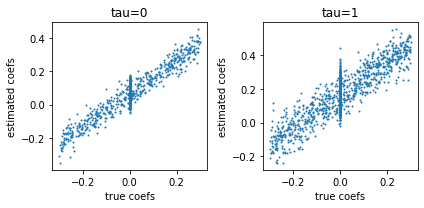

In [8]:
B_true = []
B_est = []

before_modification = []
is_modified = []

for i in range(100):
    print(f"{i:3d}", end="\r")
    B, causal_order = _generate_var_graph(is_shuffle=False)
    
    # 追加分
    B_ = _make_cycle_path(B)
    before_modification.append(B.copy())
    is_modified.append(~np.isclose(B_, B))
    B = B_
    
    X = _make_var_data(B, T=1000)
    
    # 係数の大きさに注意。発散しないように。
    if np.isnan(X).sum().sum() > 0:
        raise ValueError("X has nans")

    #model = VARLiNGAM(lags=1, prune=True)
    #model.fit(X)
    k = 3
    model = CyclicVARLiNGAM(k=k)
    model.fit(X)
    
    B_true.append(B)
    B_est.append(model.adjacency_matrices_)
    
print("  OK")

B_true = np.array(B_true)
B_est = np.array(B_est)

# 各時刻ごとに結果の係数をひとまとめにする(軸を入れ替えて100回分をそれぞれconcatして元に戻す)
concat = lambda x: np.transpose(np.concatenate(np.transpose(x, (0, 2, 3, 1))), (2, 0, 1))
_visualize(concat(B_true), concat(B_est), s=1)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


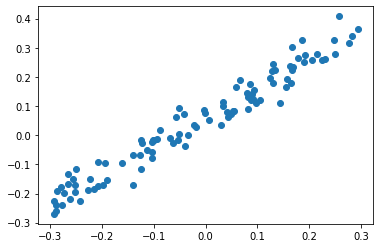

In [13]:
# 巡回部分の確認

# 巡回作成のために修正した点は元々ゼロだったか？
print(concat(before_modification)[concat(is_modified)])

# 巡回作成のために加えた箇所の推定結果
plt.scatter(
    concat(B_true)[concat(is_modified)],
    concat(B_est)[concat(is_modified)],
)
plt.show()